# 사전작업

## PKG_LOAD

### fasttext install guide(by.호재)
- pip install fasttext-wheel
- Microsoft C++ Build Tools 설치 필요
    - https://visualstudio.microsoft.com/ko/visual-cpp-build-tools/
- 결과 값에 대한 ISO 코드 확인은 다음 링크 참조(대부분의 결과는 ISO 639-1)
    - https://ko.wikipedia.org/wiki/ISO_639-1_%EC%BD%94%EB%93%9C_%EB%AA%A9%EB%A1%9D

In [2]:
import pandas as pd
import numpy as np
import fasttext
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

detec = fasttext.load_model('lid.176.ftz') # fasttext lenguage detection model
import warnings
warnings.filterwarnings(action='ignore')

## DATA불러오기

In [5]:
INQ_data = pd.read_csv('inq_data.csv', sep=',')

In [13]:
INQ = INQ_data[['MESSAGE','BLOCK_STATUS']].dropna().reset_index(drop=True)

# 전처리

## 분류지도학습을 위한 일반화
- 기존 INQUIRY 데이터의 BLOCK_STATUS 컬럼은 6개의 클래스가 존재하지만, 전체중 극히 일부의 데이터이고, 이는 전체적인 모델의 성능을 떨어트린다고 판단하여, 정상의 아닌 데이터는 전부 비정상으로 분류하는 일반화논리를 적용하였습니다.
- 정상=0, 비정상=1

In [15]:
for i in INQ['BLOCK_STATUS'].unique():
    if i == 'X':
        INQ['BLOCK_STATUS'][INQ['BLOCK_STATUS'] == i] = 0
    else:
        INQ['BLOCK_STATUS'][INQ['BLOCK_STATUS'] == i] = 1
    
INQ['BLOCK_STATUS'] = INQ['BLOCK_STATUS'].astype(int)
INQ

,MESSAGE,BLOCK_STATUS
0,"Dear Davis Brooks ,Uchida Huynh from Japan has...",0
1,"Dear Azhar Ayub,Uchida Huynh from Japan has as...",0
2,"Dear Kevin Hill,Uchida Huynh from Japan has as...",0
3,"Dear Toby ,Uchida Huynh from Japan has asked E...",0
4,"Dear Alex Empedrad,Uchida Huynh from Japan has...",0
...,...,...
402466,"We are importers of petroleum products, we int...",1
402467,\r\n\r\nHELLO\r\n\r\nWe are willing and ready ...,0
402468,"Hello,\r\n\r\nI have interest in your 7 Inch A...",0
402469,"We are GREENWORLD IMPORT EXPORT CO., LTD, once...",0


## escape 문자 제거

In [16]:
for i in np.arange(0,len(INQ['MESSAGE'])):
    a = re.sub(r'[\r\n]', ' ', INQ['MESSAGE'][i])
    INQ['MESSAGE'][i] = a

## 공백기준의 단어형태, 숫자데이터 제거와 소문자화

In [18]:
INQ['MESSAGE'] = INQ['MESSAGE'].str.replace(r'[^\w\s]', ' ', regex=True)
INQ['MESSAGE'] = INQ['MESSAGE'].str.replace(r'[0-9]', ' ', regex=True)
INQ['MESSAGE'] = INQ['MESSAGE'].str.lower()

## fasttext language detection model 사용
해당 모델은 완벽하게 language detection 을 수행하지는 못합니다. 여기서 사용되는 데이터를 api로 이용하는 것에 대한 한계점이 존재하기 때문에 대안용으로 사용되었습니다.

- 일부 외래어로 인해 언어 분류가 잘못되는 문제가 발생합니다.
    - Fasttext 의 language detection model 을 활용하여 1차적인 분류를 하였으나, 이 모델은 완벽히 언어를 분류해내지는 못합니다.
    - 이는 ferrero, nutella, nvidia, la roche posay 등의 단어로 인해 it(이탈리아)어, fr(프랑스어)로 인식하기 때문이라 추측됩니다.
- escape 문자가 존재하면 분류를 수행하지 못합니다. 실행 전 escape 문자를 제거해주세요.

In [23]:
INQ['LAN_CHECK'] = np.nan

for i in range(0,len(INQ)):
    result = detec.predict(INQ['MESSAGE'][i], k=1)
    INQ['LAN_CHECK'][i] = result[0][0][9:]

In [25]:
INQ[INQ['LAN_CHECK'] == 'ja'] # 6건
INQ[INQ['LAN_CHECK'] == 'zh'] # 2193건

,MESSAGE,BLOCK_STATUS,LAN_CHECK
2068,您好 我司需求為ul awg c 不知貴司是否可報價 ...,0,zh
2599,你好 可以做的 请问具体的规格要求 有吗 如有 请发一份到我司邮箱 sales at w...,0,zh
5333,dear maddy 請幫忙報價敝公司編號pt honey comb包裝 ...,0,zh
10438,您好 我是深圳韩润国际物流公司 在网站上看到贵公司的信息 我公司专业做韩国专线 日本专线 时...,1,zh
10439,您好 我是深圳韩润国际物流公司 在网站上看到贵公司的信息 我公司专业做韩国专线 日本专线 时...,1,zh
...,...,...,...
400645,上島食品股份有限公司 shang dao food co ltd 新北市中和...,0,zh
401013,您好 我司专注于各类hgh 多肽 类固醇以及各类激素原料出口问题 无需您提供任何化学报告...,1,zh
401014,您好 我司专注于各类hgh 多肽 类固醇以及各类激素原料出口问题 无需您提供任何化学报告...,1,zh
401015,您好 我司专注于各类hgh 多肽 类固醇以及各类激素原料出口问题 无需您提供任何化学报告...,1,zh


## 특정언어 제거
- 중국어와 일본어는 공백으로 구분되지 않는 특징을 가지고 있고, 기업과의 협의를 통하여 이런 특정 언어를 제외하고 모델링하기로 했습니다.

In [26]:
INQ['LAN_CHECK'] = INQ['LAN_CHECK'].replace('zh',np.nan)
INQ['LAN_CHECK'] = INQ['LAN_CHECK'].replace('ja',np.nan)
INQ = INQ.dropna().reset_index(drop=True)

In [27]:
INQ.groupby('BLOCK_STATUS').describe()

MESSAGE          \
               count  unique   
BLOCK_STATUS                   
0             240480  153609   
1             159792   25490   

                                                                       \
                                                            top  freq   
BLOCK_STATUS                                                            
0             buyers buyer mandate  kindly contact us immedi...   775   
1             dear sir madam     pacific energy ltd   is a v...  2127   

             LAN_CHECK                     
                 count unique top    freq  
BLOCK_STATUS                               
0               240480     71  en  238113  
1               159792     40  en  159050

## 데이터 분리

In [28]:
X = INQ['MESSAGE']
Y = INQ['BLOCK_STATUS']

## 불용어 및 stopword 지정

In [29]:
# 영어 불용어 및 load
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
# english 불용어와 중복단어리스트 합치기
list_stopwords = stopwords.words('english')

In [31]:
list_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=0)

In [33]:
print(x_train.shape)
print(y_train.shape)

(280190,)
(280190,)


## MESSAGE vectorizer

In [50]:
cv = CountVectorizer(ngram_range=(1,4), min_df=5, stop_words=list_stopwords, token_pattern=r'[A-Za-z]{3,}')
x_fit = cv.fit(x_train)

In [51]:
x_train_count = cv.transform(x_train)

In [52]:
cv.vocabulary_

{'also': 17331,
 'email': 195359,
 'address': 6159,
 'info': 304344,
 'com': 111293,
 'also email': 17852,
 'email address': 195428,
 'address info': 6722,
 'also email address': 17853,
 'email address info': 195610,
 'dear': 160710,
 'emily': 202004,
 'taylor': 668118,
 'farley': 222221,
 'aruba': 30116,
 'asked': 31580,
 'find': 229830,
 'suppliers': 653284,
 'category': 86855,
 'video': 712654,
 'game': 252304,
 'players': 486145,
 'interested': 313013,
 'please': 486287,
 'contact': 132657,
 'buyer': 74991,
 'hope': 288661,
 'take': 665684,
 'opportunity': 450180,
 'advantage': 8889,
 'sincerely': 618424,
 'premium': 502349,
 'member': 400569,
 'support': 662268,
 'team': 668407,
 'dear emily': 161612,
 'farley aruba': 222222,
 'aruba asked': 30117,
 'asked find': 31588,
 'find suppliers': 230285,
 'suppliers category': 653977,
 'category video': 88485,
 'video game': 712711,
 'game players': 252318,
 'players interested': 486149,
 'interested please': 314847,
 'please contact': 48

# MODEL - MultinominalNB

In [53]:
model = MultinomialNB(alpha = 0.0001, fit_prior = True)
model.fit(x_train_count, y_train)

MultinomialNB(alpha=0.0001)

# 모델 검증/평가

In [54]:
x_test_count = cv.transform(x_test)
y_hat = model.predict(x_test_count)

## CONFUSUION MATRIX

In [55]:
# Confusion Matrix 
cm = confusion_matrix(y_test, y_hat)
cm

array([[70603,  1541],
       [ 2769, 45169]], dtype=int64)

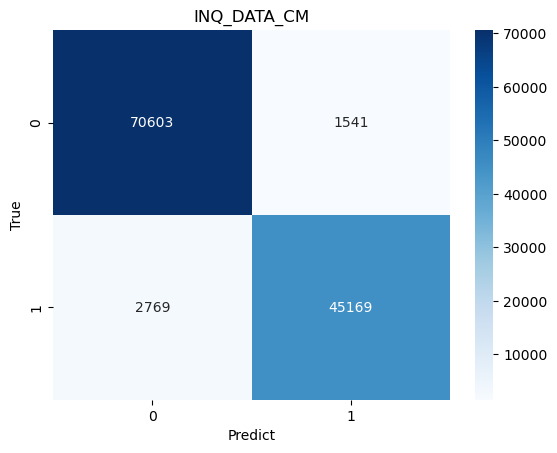

In [56]:
# Confusion Matrix plot
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g') # fmt = 'g' 를 이용해 정수표현
plt.title('INQ_DATA_CM')
plt.xlabel('Predict')
plt.ylabel('True')

plt.show()

## 종합 평가

In [58]:
print(f'Accuracy: {accuracy_score(y_test, y_hat):.3f}')
print(f'Precision:{precision_score(y_test, y_hat):.3f}')
print(f'recall:{recall_score(y_test, y_hat):.3f}')
print(f"F1_micro: {f1_score(y_test, y_hat, average='micro'):.3f}")
print(f"F1_macro: {f1_score(y_test, y_hat, average='macro'):.3f}")
print(f"F1_weight: {f1_score(y_test, y_hat, average='weighted'):.3f}")
print(f"F1_score: {f1_score(y_test, y_hat):.3f}")
pred_proba_positive = model.predict_proba(x_test_count)[:,1]
print(f'AUC: {roc_auc_score(y_test, pred_proba_positive):.3f}')

Accuracy: 0.964
Precision:0.967
recall:0.942
F1_micro: 0.964
F1_macro: 0.962
F1_weight: 0.964
F1_score: 0.954
AUC: 0.982


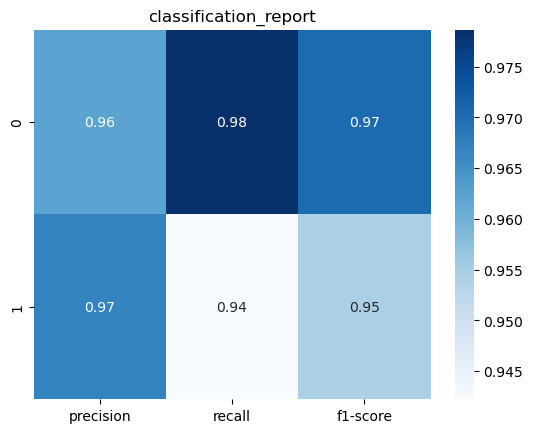

In [64]:
# 계산
cr = classification_report(y_test, y_hat, output_dict='Ture')
report_df = pd.DataFrame(cr).T

# 시각화
sns.heatmap(report_df.iloc[:2,:-1], annot=True, cmap='Blues')
plt.title('classification_report')
plt.show()

## ROC_AUC CURVE

In [59]:
fpr, tpr, threshold = roc_curve(y_test, pred_proba_positive)
roc_auc = auc(fpr, tpr)

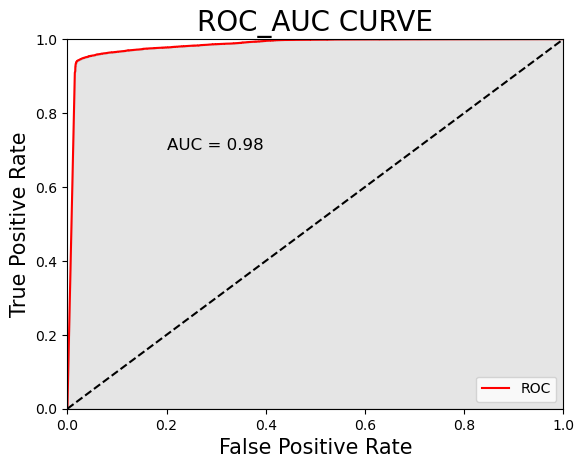

In [60]:
plt.plot(fpr,tpr, color='red', label='ROC')
plt.title('ROC_AUC CURVE', size=20)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='best')
plt.fill_between(fpr, tpr, 0, alpha=0.2, color='grey')
plt.text(0.2, 0.7, 'AUC = %0.2f' % roc_auc, fontsize=12)
plt.show()

## 평균교차검증

In [ ]:
X_count = cv.fit_transform(X)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(model, X_count, Y, scoring='accuracy', cv=stratified_kfold)
# 기존 cv 값을 5로 주었을 경우 평균 검증 정확도가 0.89 편차가 +- 0.5 이었으나, stratified_kfold 를 cv 값을 줌으로서 안정적인 분류를 해냈음 
print('교차 검증별 정확도: ', np.round(scores,3))
print('평균 검증 정확도: ', np.round(np.mean(scores),3))

# 하이퍼파라메터 조합

In [63]:
# MultinomialNB 파라메터 정의
hyperparameters = {
    'alpha': np.linspace(0.0001, 1),
    'fit_prior': [True, False]
}

clf = MultinomialNB()

grid_search = GridSearchCV(clf, hyperparameters, cv=5)
grid_search.fit(x_train_count, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'alpha': 0.0001, 'fit_prior': True}
